
#  オペレーティングシステム 演習 08
#  Compare-and-swap / 各種不可分更新方法のの可視化


名前と学生証番号を書け. Enter your name and student ID.

 * 名前 Name:
 * 学生証番号 Student ID:


# 1. 始めに
* 1変数に対する不可分な更新を行うのには排他制御を使う方法と不可分更新命令を使う方法がある
* 排他制御にも休眠待機を行うもの(pthread_mutex_t)と, ビジーウェイトを行うもの(pthread_spinlock_t)がある
* 変数の更新を行う3つの方法を試してその挙動を可視化しよう

* 以下はどれも全スレッドで合計n回, 

```
g = compute(g, l);
```

という文を(gを読み出してから更新するまでを)不可分に実行する. 排他制御を使う場合は,
```
lock();
g = compute(g, l);
unlock();
```

compute(g) の中身に特に意味はないが,
```
double compute(x, l) {
  for (i = 0; i < l; i++) {
    x = a * x + b
  }
  return x;
}
```

* 可視化をしやすくするため, クリティカルセクションの外で適当な時間だけsleepできるようにする
```
./lock_rec_xxx nthreads n l s
```
で, 
```
/* Nスレッド合計でn回 */
for (long i = 0; i < n; i++) {
    g = compute(g, l); // 不可分に
    s秒休眠
}
```
という動きをする

# 2. 可視化のためのプログラム

In [5]:
#!/usr/bin/python3
import sys
import re
import matplotlib.collections as mc
import matplotlib.pyplot as plt
import numpy as np

def read_dat(dat):
    pat = re.compile(r"(?P<i>\d+) (?P<thread>\d+) (?P<cpu>\d+) (?P<lock_enter>\d+\.\d+) (?P<lock_acq>\d+\.\d+) (?P<unlock_enter>\d+\.\d+)")
    log = {}
    with open(dat) as fp:
        for line in fp:
            m = pat.match(line)
            if not m:
                sys.stderr.write("warning: ignore line [%s]\n" % line.rstrip())
                continue
            i = int(m.group("i"))
            thread = int(m.group("thread"))
            cpu = int(m.group("cpu"))
            lock_enter = float(m.group("lock_enter"))
            lock_acq = float(m.group("lock_acq"))
            unlock_enter = float(m.group("unlock_enter"))
            if thread not in log:
                log[thread] = []
            log[thread].append((i, cpu, lock_enter, lock_acq, unlock_enter))
    return log
    
def progress_threads_plt(dat, start_t, end_t):
    log = read_dat(dat)
    nthreads = len(log)
    #cmap = plt.cm.get_cmap('RdYlGn', nthreads)
    cmap = plt.get_cmap('RdYlGn', nthreads)
    T0 = min(min(t for _, _, t, _, _ in recs) for recs in log.values())
    lines = []
    names = []
    fig, ax = plt.subplots()
    for thread, recs in sorted(log.items()):
        T = [unlock - T0 for _, _, _, _, unlock in recs if start_t <= unlock - T0 < end_t]
        N = list(range(len(T)))
        color = cmap(thread)
        lines.extend(ax.plot(T, N, 'o', markersize=0.5, color=color))
        names.append(thread)
    ax.autoscale()
    plt.title("progress of threads (%s)" % dat)
    plt.xlabel("time")
    plt.ylabel("updates (by thread)")
    # plt.legend(lines, names)
    plt.show()

def progress_threads_plts(dats, start_t=0, end_t=float("inf")):
    for dat in dats:
        progress_threads_plt(dat, start_t, end_t)

def compare_progress_plt(dat, color, fig, ax, start_t, end_t):
    log = read_dat(dat)
    T0 = min(min(t for _, _, t, _, _ in recs) for recs in log.values())
    T = []
    for thread, recs in sorted(log.items()):
        T.extend([unlock - T0 for _, _, _, _, unlock in recs if start_t <= unlock - T0 < end_t])
        # G.extend([i             for i, _, _, _, _ in recs])
        # color = cmap(thread)
    T.sort()
    N = list(range(len(T)))
    [l] = ax.plot(T, N, 'o', markersize=0.5, color=color)
    return (l, dat)
        
def compare_progress_plts(dats, start_t=0, end_t=float("inf")):
    n_methods = len(dats)
    cmap = plt.cm.get_cmap('RdYlGn', n_methods)
    fig, ax = plt.subplots()
    labels = []
    for i,dat in enumerate(dats):
        color = cmap(i)
        labels.append(compare_progress_plt(dat, color, fig, ax, start_t, end_t))
    ax.autoscale()
    lines = [l   for l,dat in labels]
    names = [dat for l,dat in labels]
    plt.title("compare methods")
    plt.xlabel("time")
    plt.ylabel("updates (total)")
    plt.legend(lines, names)
    plt.show()

def lock_wait_gantt(dat, start_t, end_t):
    log = read_dat(dat)
    n_cpus = max(max(cpu for _, cpu, _, _, _ in recs) for recs in log.values()) + 1
    n_threads = len(log)
    #cmap = plt.cm.get_cmap('RdYlGn', n_threads)
    cmap = plt.get_cmap('RdYlGn', n_threads)
    T0 = min(min(t for _, _, t, _, _ in recs) for recs in log.values())
    lock_wait_segs = []
    lock_held_segs = []
    wait_colors = []
    held_colors = []
    fig, ax = plt.subplots()
    for thread, recs in sorted(log.items()):
        c = cmap(thread)
        d = tuple([x + 0.8 * (1 - x) for x in c])
        for i, cpu, lock_enter, lock_acq, unlock_enter in recs:
            w0 = max(lock_enter - T0, start_t)
            w1 = min(lock_acq - T0, end_t)
            h0 = max(lock_acq - T0, start_t)
            h1 = min(unlock_enter - T0, end_t)
            if w0 <= w1:
                lock_wait_segs.append([(w0, thread), (w1, thread)])
                wait_colors.append(c)
            if h0 <= h1:
                lock_held_segs.append([(h0, thread), (h1, thread)])
                held_colors.append(d)
    lw = 320 / n_threads
    wc = mc.LineCollection(lock_wait_segs, colors=held_colors, linewidths=lw/2)
    hc = mc.LineCollection(lock_held_segs, colors=wait_colors, linewidths=lw)
    ax.add_collection(wc)
    ax.add_collection(hc)
    ax.autoscale()
    plt.title("thread status (%s)" % dat)
    plt.xlabel("time")
    plt.ylabel("threads")
    plt.show()

def lock_wait_gantts(dats, start_t=0, end_t=float("inf")):
    for dat in dats:
        lock_wait_gantt(dat, start_t, end_t)

def main():
    dats = sys.argv[1:]
    compare_progress_plts(dats)
    lock_wait_gantts(dats)
    progress_threads_plts(dats)

#if __name__ == "__main__":
#    main()

# 3. mutex
* まずは最も基本的な, mutex を使う方法

In [2]:
%%writefile lock_rec_mutex.c
#define _GNU_SOURCE
#include <assert.h>
#include <stdio.h>
#include <stdlib.h>
#include <unistd.h>
#include <sched.h>
#include <pthread.h>
#include <omp.h>

void die(const char * msg) {
  perror(msg); exit(1);
}

/* 大域変数 */
volatile double g;

double cur_time() {
  struct timespec ts[1];
  clock_gettime(CLOCK_REALTIME, ts);
  return ts->tv_sec + ts->tv_nsec * 1.0e-9;
}

void waste_sec(double dt) {
  if (dt > 0) {
    double t0 = cur_time();
    while (cur_time() < t0 + dt) ;
  }
}

/* pthread_mutexで排他制御 */
typedef pthread_mutex_t mutex_t;
int mutex_init(mutex_t * m) {
  return pthread_mutex_init(m, 0);
}
int mutex_lock(mutex_t * m) {
  return pthread_mutex_lock(m);
}
int mutex_unlock(mutex_t * m) {
  return pthread_mutex_unlock(m);
}

/* x = ax + b を l 回行う(特に意味のない計算) */
double compute(double a, double x, double b, long l) {
  for (long i = 0; i < l; i++) {
    x = a * x + b;
  }
  return x;
}

typedef struct {
  double t[2];
} double2_t;

double2_t atomic_update(double a, volatile double * p, double b, long l, mutex_t * m) {
  mutex_lock(m);
  double t1 = cur_time();
  *p = compute(a, *p, b, l);
  double t2 = cur_time();
  mutex_unlock(m);
  double2_t t = {{t1, t2}};
  return t;
}


/* 記録 */
typedef struct {
  int thread;                   /* スレッド番号 */
  int cpu;                      /* CPU番号 */
  double lock_enter;            /* lockを呼んだ時刻 */
  double lock_acq;              /* lockがreturnした(獲得した)時刻 */
  double unlock_enter;          /* unlockを呼んだ時刻 */
} record_t;

int main(int argc, char ** argv) {
  int i = 1;
  /* スレッド数 */
  long nthreads = (argc > i ? atol(argv[i]) : 4);    i++;
  /* (合計)更新数 */
  long n        = (argc > i ? atol(argv[i]) : 100000); i++;
  /* 1回の更新あたりの時間 (x = ax+b の回数)
     クリティカルセクションの長さを調節 */
  long l        = (argc > i ? atol(argv[i]) : 1000); i++;
  /* クリティカルセクション外の時間(秒) */
  double time_out = (argc > i ? atof(argv[i]) : 0);    i++;

  double a = (argc > i ? atof(argv[i]) : 1.0 - 1.0e-10); i++;
  double b = (argc > i ? atof(argv[i]) : 1.0); i++;
  
  g = 0.0;
  mutex_t m[1];
  mutex_init(m);
  record_t * rec = (record_t *)calloc(sizeof(record_t) * n, 1);
  
#pragma omp parallel num_threads(nthreads) 
  {
    int idx = omp_get_thread_num();
#pragma omp for schedule(static)
    for (long i = 0; i < n; i++) {
      double t0 = cur_time();
      double2_t t12 = atomic_update(a, &g, b, l, m);
      waste_sec(time_out);
      rec[i].thread = idx;
      rec[i].cpu = sched_getcpu();
      rec[i].lock_enter = t0;
      rec[i].lock_acq = t12.t[0];
      rec[i].unlock_enter = t12.t[1];
    }
  }
  printf("g = %lf\n", g);
  for (long i = 0; i < n; i++) {
    printf("%ld %d %d %.9f %.9f %.9f\n", i, rec[i].thread, rec[i].cpu,
           rec[i].lock_enter, rec[i].lock_acq, rec[i].unlock_enter);
  }
  return 0;
}

Writing lock_rec_mutex.c


In [3]:
gcc -Wall -fopenmp -o lock_rec_mutex lock_rec_mutex.c

* 実行

In [6]:
nthreads=4
n=100000
l=1000
s=1.0e-6
set=2-5
/usr/bin/time taskset -c ${set} ./lock_rec_mutex ${nthreads} ${n} ${l} ${s} > mutex.dat

0.63user 0.13system 0:00.54elapsed 140%CPU (0avgtext+0avgdata 4864maxresident)k
0inputs+14240outputs (0major+954minor)pagefaults 0swaps


* 可視化
* start_t= と end_t= を指定して, 特定の区間だけを表示する(適宜変更してみよ)

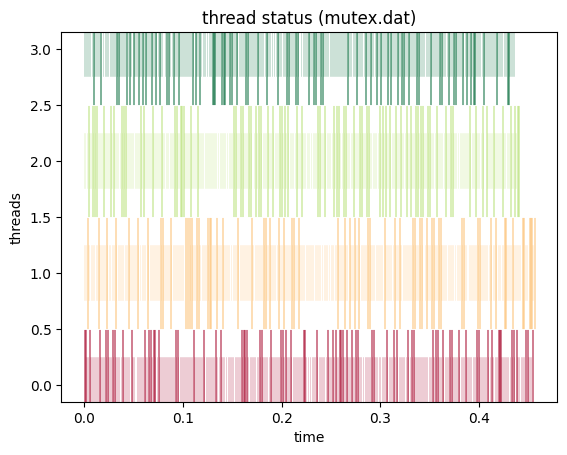

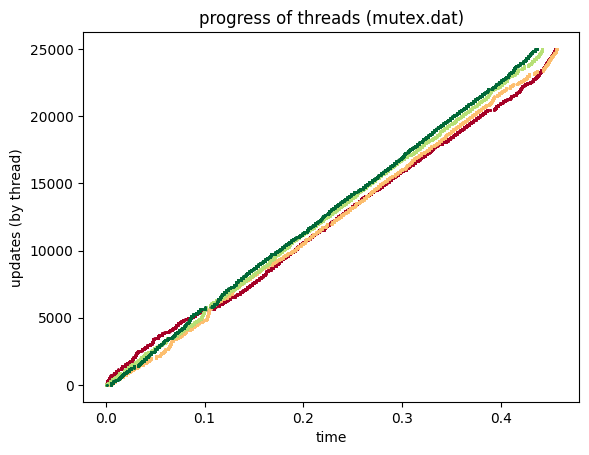

/tmp/ipykernel_50515/2789954552.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn', n_methods)


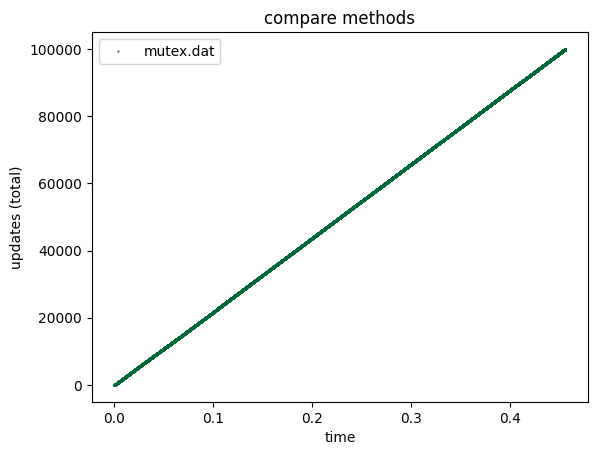

In [7]:
start_t = 0
end_t = float("inf")
lock_wait_gantts(["mutex.dat"], start_t=start_t, end_t=end_t)
progress_threads_plts(["mutex.dat"], start_t=start_t, end_t=end_t)
compare_progress_plts(["mutex.dat"], start_t=start_t, end_t=end_t)

* <font color="purple">上記でパラメータを色々変えて試してみよ</font>

* taskset -c 2-5 は CPU 2-5 (本当は仮想コア) を使うという意味.
* N CPU (本当は仮想コア)がある環境では, 0 〜 $N - 1$ までの仮想コア番号を指定できる
* /usr/bin/time というコマンドでプロセスの使用したCPU時間を表示している

```
0.67user 0.20system 0:00.67elapsed 129%CPU (0avgtext+0avgdata 5140maxresident)k
0inputs+14240outputs (0major+962minor)pagefaults 0swaps
```

は ユーザ時間が0.67秒, システム(OS)時間が0.20秒消費したことを示している

* 注目点
  * 1つめのグラフは各スレッドがクリティカルセクションの中を実行している部分を濃い太線で表示している. クリティカルセクションが時間的に重なっていないことを確認せよ
  * mutex lockに入ってからリターンするまで(つまり, lockを待っている時間)を薄い線で表示している. スレッドが増えるとほとんどの時間が待ち時間になることを観察せよ
  * 使用CPU数を固定してスレッド数nthreadsを増やすと結果(経過時間, CPUの消費時間)がどう変わるかを試してみよ
  * 同じスレッド数でCPU数を増やすとどうなるか?

# 4. spinlock
* spinlock は排他制御と同じだが, lockが獲得できるまでブロックせずにビジーウェイトする

In [ ]:
%%writefile lock_rec_spin.c
#define _GNU_SOURCE
#include <assert.h>
#include <stdio.h>
#include <stdlib.h>
#include <unistd.h>
#include <sched.h>
#include <pthread.h>
#include <omp.h>

void die(const char * msg) {
  perror(msg); exit(1);
}

/* 大域変数 */
volatile double g;

double cur_time() {
  struct timespec ts[1];
  clock_gettime(CLOCK_REALTIME, ts);
  return ts->tv_sec + ts->tv_nsec * 1.0e-9;
}

void waste_sec(double dt) {
  if (dt > 0) {
    double t0 = cur_time();
    while (cur_time() < t0 + dt) ;
  }
}

/* pthread_spin_lockで排他制御 */
typedef pthread_spinlock_t mutex_t;
int mutex_init(mutex_t * m) {
  return pthread_spin_init(m, 0);
}
int mutex_lock(mutex_t * m) {
  return pthread_spin_lock(m);
}
int mutex_unlock(mutex_t * m) {
  return pthread_spin_unlock(m);
}

/* x = ax + b を l 回行う(特に意味のない計算) */
double compute(double a, double x, double b, long l) {
  for (long i = 0; i < l; i++) {
    x = a * x + b;
  }
  return x;
}

typedef struct {
  double t[2];
} double2_t;

double2_t atomic_update(double a, volatile double * p, double b, long l, mutex_t * m) {
  mutex_lock(m);
  double t1 = cur_time();
  *p = compute(a, *p, b, l);
  double t2 = cur_time();
  mutex_unlock(m);
  double2_t t = {{t1, t2}};
  return t;
}


/* 記録 */
typedef struct {
  int thread;                   /* スレッド番号 */
  int cpu;                      /* CPU番号 */
  double lock_enter;            /* lockを呼んだ時刻 */
  double lock_acq;              /* lockがreturnした(獲得した)時刻 */
  double unlock_enter;          /* unlockを呼んだ時刻 */
} record_t;

int main(int argc, char ** argv) {
  int i = 1;
  /* スレッド数 */
  long nthreads = (argc > i ? atol(argv[i]) : 4);    i++;
  /* (合計)更新数 */
  long n        = (argc > i ? atol(argv[i]) : 100000); i++;
  /* 1回の更新あたりの時間 (x = ax+b の回数)
     クリティカルセクションの長さを調節 */
  long l        = (argc > i ? atol(argv[i]) : 1000); i++;
  /* クリティカルセクション外の時間(秒) */
  double time_out = (argc > i ? atof(argv[i]) : 0);    i++;

  double a = (argc > i ? atof(argv[i]) : 1.0 - 1.0e-10); i++;
  double b = (argc > i ? atof(argv[i]) : 1.0); i++;
  
  g = 0.0;
  mutex_t m[1];
  mutex_init(m);
  record_t * rec = (record_t *)calloc(sizeof(record_t) * n, 1);
  
#pragma omp parallel num_threads(nthreads) 
  {
    int idx = omp_get_thread_num();
#pragma omp for schedule(static)
    for (long i = 0; i < n; i++) {
      double t0 = cur_time();
      double2_t t12 = atomic_update(a, &g, b, l, m);
      waste_sec(time_out);
      rec[i].thread = idx;
      rec[i].cpu = sched_getcpu();
      rec[i].lock_enter = t0;
      rec[i].lock_acq = t12.t[0];
      rec[i].unlock_enter = t12.t[1];
    }
  }
  printf("g = %lf\n", g);
  for (long i = 0; i < n; i++) {
    printf("%ld %d %d %.9f %.9f %.9f\n", i, rec[i].thread, rec[i].cpu,
           rec[i].lock_enter, rec[i].lock_acq, rec[i].unlock_enter);
  }
  return 0;
}

In [ ]:
BEGIN SOLUTION
END SOLUTION
gcc -Wall -fopenmp -o lock_rec_spin lock_rec_spin.c

In [ ]:
nthreads=4
n=100000
l=1000
s=1.0e-6
set=2-5
/usr/bin/time taskset -c ${set} ./lock_rec_spin ${nthreads} ${n} ${l} ${s} > spin.dat

In [ ]:
start_t = 0
end_t = float("inf")
lock_wait_gantts(["spin.dat"], start_t=start_t, end_t=end_t)
progress_threads_plts(["spin.dat"], start_t=start_t, end_t=end_t)
compare_progress_plts(["spin.dat"], start_t=start_t, end_t=end_t)

* <font color="purple">同様にパラメータを変えて試してみよ</font>

* 注目点
  * CPUの利用時間 (/usr/bin/timeが表示する)
  * スレッド数 &gt; コア数(tasksetで指定したCPU数)の場合の挙動
  * スレッド数 &lt;= コア数の場合の経過時間 (mutexの場合との比較)
  * spinlockの方がmutexに勝る, 負けるのはどう言う場合か?

# 5. 不可分更新 (compare-and-swap)
```
g = compute(g, l)
```
を不可分に行うために, lockを用いずにcompare-and-swap命令を用いて以下のようにする.
排他制御を行っていないので, lockの待ち時間は存在しない.

```
while (1) {
  double x = g;
  double y = compute(x, l);
  if (compare_and_swap(&g, x, y)) break;
}
```

In [ ]:
%%writefile lock_rec_cas.c
#define _GNU_SOURCE
#include <assert.h>
#include <stdio.h>
#include <stdlib.h>
#include <unistd.h>
#include <sched.h>
#include <pthread.h>
#include <omp.h>

void die(const char * msg) {
  perror(msg); exit(1);
}

/* 大域変数 */
volatile double g;

double cur_time() {
  struct timespec ts[1];
  clock_gettime(CLOCK_REALTIME, ts);
  return ts->tv_sec + ts->tv_nsec * 1.0e-9;
}

void waste_sec(double dt) {
  if (dt > 0) {
    double t0 = cur_time();
    while (cur_time() < t0 + dt) ;
  }
}

/* 排他制御なし(以下はダミー) */
typedef int mutex_t;
int mutex_init(mutex_t * m) { *m = 0; return 0; }
int mutex_lock(mutex_t * m) { (void)m; return 0; }
int mutex_unlock(mutex_t * m) { (void)m; return 0; }

/* x = ax + b を l 回行う(特に意味のない計算) */
double compute(double a, double x, double b, long l) {
  for (long i = 0; i < l; i++) {
    x = a * x + b;
  }
  return x;
}

typedef struct {
  double t[2];
} double2_t;

int compare_and_swap_double(volatile double * p, double x, double y) {
  union { long l; double d; } o, n;
  o.d = x;
  n.d = y;
  return __sync_bool_compare_and_swap((long *)p, o.l, n.l);
}

double2_t atomic_update(double a, volatile double * p, double b, long l, mutex_t * m) {
  (void)m;
  while (1) {
    double t1 = cur_time();
    double x = *p;
    double y = compute(a, x, b, l);
    assert(x != y);
    if (compare_and_swap_double(p, x, y)) {
      double t2 = cur_time();
      double2_t t = {{t1, t2}};
      return t;
    }
  }
  assert(0);
}

/* 記録 */
typedef struct {
  int thread;                   /* スレッド番号 */
  int cpu;                      /* CPU番号 */
  double lock_enter;            /* lockを呼んだ時刻 */
  double lock_acq;              /* lockがreturnした(獲得した)時刻 */
  double unlock_enter;          /* unlockを呼んだ時刻 */
} record_t;

int main(int argc, char ** argv) {
  int i = 1;
  /* スレッド数 */
  long nthreads = (argc > i ? atol(argv[i]) : 4);    i++;
  /* (合計)更新数 */
  long n        = (argc > i ? atol(argv[i]) : 100000); i++;
  /* 1回の更新あたりの時間 (x = ax+b の回数)
     クリティカルセクションの長さを調節 */
  long l        = (argc > i ? atol(argv[i]) : 1000); i++;
  /* クリティカルセクション外の時間(秒) */
  double time_out = (argc > i ? atof(argv[i]) : 0);    i++;

  double a = (argc > i ? atof(argv[i]) : 1.0 - 1.0e-10); i++;
  double b = (argc > i ? atof(argv[i]) : 1.0); i++;
  
  g = 0.0;
  mutex_t m[1];
  mutex_init(m);
  record_t * rec = (record_t *)calloc(sizeof(record_t) * n, 1);
  
#pragma omp parallel num_threads(nthreads) 
  {
    int idx = omp_get_thread_num();
#pragma omp for schedule(static)
    for (long i = 0; i < n; i++) {
      double t0 = cur_time();
      double2_t t12 = atomic_update(a, &g, b, l, m);
      waste_sec(time_out);
      rec[i].thread = idx;
      rec[i].cpu = sched_getcpu();
      rec[i].lock_enter = t0;
      rec[i].lock_acq = t12.t[0];
      rec[i].unlock_enter = t12.t[1];
    }
  }
  printf("g = %lf\n", g);
  for (long i = 0; i < n; i++) {
    printf("%ld %d %d %.9f %.9f %.9f\n", i, rec[i].thread, rec[i].cpu,
           rec[i].lock_enter, rec[i].lock_acq, rec[i].unlock_enter);
  }
  return 0;
}

In [ ]:
BEGIN SOLUTION
END SOLUTION
gcc -Wall -fopenmp -o lock_rec_cas lock_rec_cas.c

In [ ]:
nthreads=4
n=100000
l=1000
s=1.0e-6
set=2-5
/usr/bin/time taskset -c ${set} ./lock_rec_cas ${nthreads} ${n} ${l} ${s} > cas.dat

In [ ]:
start_t = 0
end_t = float("inf")
lock_wait_gantts(["cas.dat"], start_t=start_t, end_t=end_t)
progress_threads_plts(["cas.dat"], start_t=start_t, end_t=end_t)
compare_progress_plts(["cas.dat"], start_t=start_t, end_t=end_t)

* <font color="purple">同様に上記のパラメータを変えて試してみよ</font>

* 注目点
  * CPUの利用時間 (/usr/bin/timeが表示する)
  * スレッド数 &lt;= 使用CPU数のときの挙動
  * スレッド数 &gt; 使用CPU数のときの挙動

# <font color="green"> Problem 1 :  3者の比較</font>

* 3通りの方法を同じパラメータで実行してそれらを可視化して比較せよ
* パラメータを色々変化させてどのように結果が変わるかを調べよ

In [ ]:
BEGIN SOLUTION
END SOLUTION
nthreads=4
n=100000
l=1000
s=1.0e-6
set=2-5
/usr/bin/time taskset -c ${set} ./lock_rec_mutex ${nthreads} ${n} ${l} ${s} > mutex.dat
/usr/bin/time taskset -c ${set} ./lock_rec_spin ${nthreads}  ${n} ${l} ${s} > spin.dat
/usr/bin/time taskset -c ${set} ./lock_rec_cas ${nthreads}   ${n} ${l} ${s} > cas.dat

In [ ]:
BEGIN SOLUTION
END SOLUTION
start_t = 0
end_t = float("inf")
compare_progress_plts(["mutex.dat", "spin.dat", "cas.dat"], start_t=start_t, end_t=end_t)

* spinlock の方が mutex よりも有利なのはどういう状況か?
* spinlock が不利になるのはどういう状況か? 可視化された結果を元に何が起きているのかを述べよ
* その状況で compare-and-swap を使う方法では何が起きるか? 不利にならないのはなぜか?

BEGIN SOLUTION
END SOLUTION
(解答欄)


